In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import DynUNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)

import math


In [2]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-001'
adcm_dir = '/homes/zshahpouri/DLP/ASC-PET-001/ADCM'
directory = '/homes/zshahpouri/DLP/Practic/LOGTEST'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'

In [3]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "ADCM", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]


# Calculate split sizes
total_size = len(data_dicts)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
# The test set gets the remaining data points
test_size = total_size - train_size - val_size

# Split the dataset
train_files = data_dicts[:train_size]
val_files = data_dicts[train_size:(train_size + val_size)]
test_files = data_dicts[(train_size + val_size):]


In [4]:
print(len(test_files))
print(len(val_files))
print(len(train_files))


20
36
128


In [5]:
from monai.transforms import NormalizeIntensityd


patch_size = [168, 168, 16]
spacing = [4.07, 4.07, 3.00]
spatial_size = (168, 168, 320)
train_transforms = Compose(

    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # NormalizeIntensityd(keys=[ "target"]),
        Spacingd(keys=["image", "target"], pixdim= spacing, mode= 'trilinear'),
        
        SpatialPadd(keys=["image", "target"], spatial_size=spatial_size, mode='constant'),  # Pad to ensure minimum size
        
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size = patch_size,
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=spacing, mode= 'trilinear'),
        SpatialPadd(keys=["image", "target"], spatial_size=spatial_size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=spatial_size),  # Ensure uniform size
    ])

# test_transforms = Compose(
#     [   LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
#         SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
#         CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
#     ])


train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=8)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)


Loading dataset:   0%|          | 0/128 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]


image shape: torch.Size([168, 168, 320]), target shape: torch.Size([168, 168, 320])


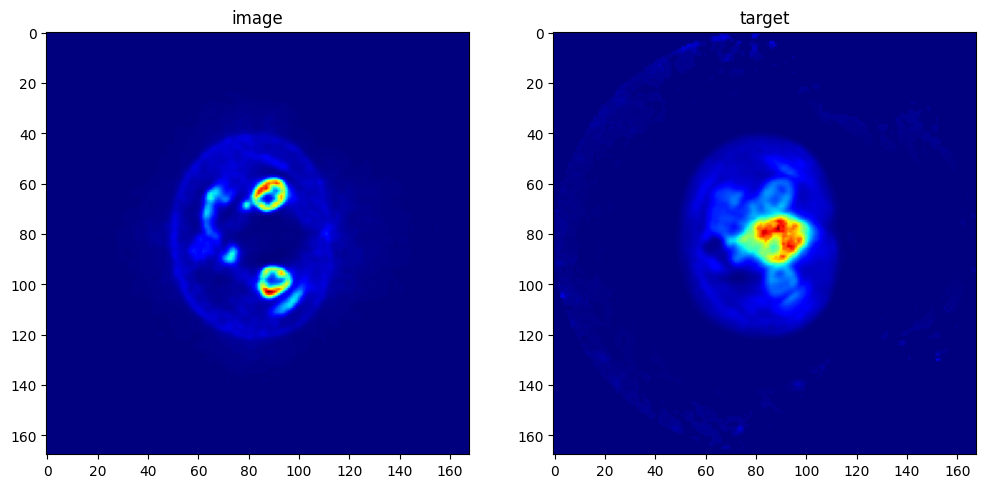

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 150

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="jet")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='jet' )
plt.show()

In [7]:
import os
import datetime
from datetime import datetime


class TrainingLogger:
    def __init__(self, directory):
        self.directory = directory
        self.ensure_directory_exists(self.directory)
        self.log_file = self.create_log_file()

    def ensure_directory_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def create_log_file(self):
        filename = f"{self.directory}/log_{self.get_date()}.txt"
        return open(filename, "w")

    def get_date(self):

        s = datetime.now()
        date = f"{s.month}_{s.day}_{s.hour}_{s.minute}"
        return date

    def log(self, message):
        print(message)
        self.log_file.write(message + "\n")

    def close(self):
        self.log_file.close()

In [8]:
starting_epoch = 0
decay_epoch = 5
learning_rate = 0.001

import torch
from monai.networks.nets import DynUNet
from torch import nn

class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (self.epochs - self.decay_epochs)
    


---------
# Network Parameters Finder

In [9]:
import os
import torch
from monai.networks.nets import DynUNet

def get_kernels_strides(patch_size, spacing):
    """
    Adjusted function to use the correct variable names.
    """
    sizes = patch_size  
    spacings = spacing  
    strides, kernels = [], []
    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        for idx, (i, j) in enumerate(zip(sizes, stride)):
            if i % j != 0:
                raise ValueError(
                    f"Patch size is not supported, please try to modify the size {patch_size[idx]} in the spatial dimension {idx}."
                )
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)

    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])
    return kernels, strides


def get_network(patch_size, spacing):
    """
    Initializes the DynUNet with dynamically determined kernels and strides.
    """
    kernels, strides = get_kernels_strides(patch_size, spacing)
    print(kernels)
    print(strides)
    print(len(strides))
    net = DynUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        kernel_size=kernels,
        strides=strides,
        upsample_kernel_size=strides[1:],
        norm_name="instance",
        deep_supervision=True,
        deep_supr_num=2,
    )
    return net

# Example usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size, spacing)
model = model.to(device)
model

[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]
4


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

In [10]:
# kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
# strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]
# len(strides): 4
# filters : [64, 96, 128, 192, 256, 384, 512, 768, 1024][: len(strides)]
# filters: [64, 96, 128, 192]

In [11]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Adjust these parameters according to your dataset and requirements
# spatial_dims = 3
# in_channels = 1
# out_channels = 1
# kernel_size = [3, 3, 3]  # Example values, adjust based on your needs
# strides = [1, 2, 2]  # Example values, adjust based on your needs
# upsample_kernel_size = [2, 2, 2]  # Example values, adjust based on your needs

# model = DynUNet(
#     spatial_dims=spatial_dims,
#     in_channels=in_channels,
#     out_channels=out_channels,
#     kernel_size=kernel_size,
#     strides=strides,
#     upsample_kernel_size=upsample_kernel_size,
#     # filters=(32, 64, 128),
#     dropout=0.1,
#     norm_name=("INSTANCE", {"affine": True}),
#     act_name=("RELU", {"inplace": True}),
#     deep_supervision=True,
#     deep_supr_num=1,
# ).to(device)



In [12]:
loss_function = torch.nn.MSELoss()

print('Defining optimizer...')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

max_epochs = 250
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

# Define scheduler
print('Defining scheduler...')
lr_lambda = DecayLR(epochs=max_epochs, offset=0, decay_epochs=decay_epoch).step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

Defining optimizer...
Defining scheduler...


In [13]:
def deep_loss(outputs, target, loss_function, device, weights=None):
    """
    Compute the deep supervision loss for each output feature map.

    Parameters:
    - outputs: Tensor containing all output feature maps, including the final prediction.
    - target: The ground truth tensor.
    - loss_function: The loss function to apply.
    - device: The device on which to perform the calculations.
    - weights: A list of weights for each output's loss. Defaults to equal weighting if None.

    Returns:
    - Weighted average of the computed losses.
    """
    # Unbind the outputs along the first dimension to handle each feature map individually
    output_maps = torch.unbind(outputs, dim=1)
    
    if weights is None:
        # If no weights specified, use equal weights
        weights = [1.0 / len(output_maps)] * len(output_maps)
    elif sum(weights) != 1:
        # Normalize weights to sum to 1
        total = sum(weights)
        weights = [w / total for w in weights]

    total_loss = 0.0
    for output, weight in zip(output_maps, weights):
        # Resize target to match the output size if necessary
        resized_target = torch.nn.functional.interpolate(target, size=output.shape[2:], mode='nearest').to(device)
        # Compute loss for the current output
        loss = loss_function(output, resized_target)
        # Accumulate weighted loss
        total_loss += weight * loss

    return total_loss



In [14]:


class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_function, scheduler, max_epochs, val_interval, directory, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.scheduler = scheduler  # Add scheduler to the class initialization
        self.max_epochs = max_epochs
        self.val_interval = val_interval
        self.directory = directory
        self.device = device  # Assuming device is passed as a parameter
        self.logger = TrainingLogger(directory)
        self.best_metric = float('inf')
        self.best_metric_epoch = -1


    def log(self):
        self.logger.log(f"train set: {len(train_files)}" )
        self.logger.log(f"validation set: {len(val_files)}")
        self.logger.log(f"max_epochs: {max_epochs}")
        self.logger.log(f"val_interval: {val_interval}")
        self.logger.log(f"model.filters: {model.filters}")



    def train(self):
        for epoch in range(self.max_epochs):
            self.logger.log("-" * 10)
            self.logger.log(f"epoch {epoch + 1}/{self.max_epochs}")

            self.model.train()
            epoch_loss = 0
            step = 0

            for batch_data in self.train_loader:
                step += 1
                inputs, targets = batch_data["image"].to(self.device), batch_data["target"].to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)

                # Check if deep supervision is used
                if isinstance(outputs, tuple) or (outputs.dim() > targets.dim()):
                    # Outputs from deep supervision
                    loss = deep_loss(outputs, targets, loss_function, device)
                else:
                    # Standard output handling
                    outputs = torch.squeeze(outputs)
                    targets = torch.squeeze(targets, dim=1)  # Adjust for channel dimension if necessary
                    loss = loss_function(outputs, targets)
                

                # loss = self.loss_function(outputs, targets)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                self.logger.log(f"{step}/{len(self.train_loader.dataset) // self.train_loader.batch_size}, train_loss: {loss.item():.4f}")

            epoch_loss /= step
            self.logger.log(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Step the scheduler here, after the training phase and before the validation phase
            self.scheduler.step()
            self.logger.log(f"current lr: {self.scheduler.get_last_lr()[0]}")

            # Validation logic remains largely the same
            if (epoch + 1) % self.val_interval == 0:
                self.model.eval()
                val_loss = 0
                roi_size = (168, 168, 32)
                sw_batch_size = 16
                
                with torch.no_grad():
                    for val_data in self.val_loader:
                        val_inputs, val_targets = val_data["image"].to(self.device), val_data["target"].to(self.device)

                        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                        val_loss += self.loss_function(val_outputs, val_targets).item()

                val_loss /= len(self.val_loader)
                self.logger.log(f"Validation loss: {val_loss:.4f}")

                if val_loss < self.best_metric:
                    self.best_metric = val_loss
                    self.best_metric_epoch = epoch + 1
                    self.save_model()

        self.logger.close()

    def save_model(self):
        model_filename = f"model_{self.logger.get_date()}.pth"
        torch.save(self.model.state_dict(), os.path.join(self.directory, model_filename))
        self.logger.log(f"Saved {model_filename} model, best_metric: {self.best_metric:.4f}, epoch: {self.best_metric_epoch}")


    
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, loss_function, scheduler, max_epochs, val_interval,directory, device)
trainer.log()
trainer.train()

train set: 128
validation set: 36
max_epochs: 250
val_interval: 2
model.filters: [32, 64, 128, 256]
----------
epoch 1/250


In [ ]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


# log_filename = 'log_2_19_8_7.txt'
log_filename = 'log_2_26_9_11.txt'
log_filename = 'log_2_28_8_59.txt'
log_filename = 'log_3_4_12_4.txt'

log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_3_4_14_35.pth, Best Metric: 0.0342, Epoch: 30


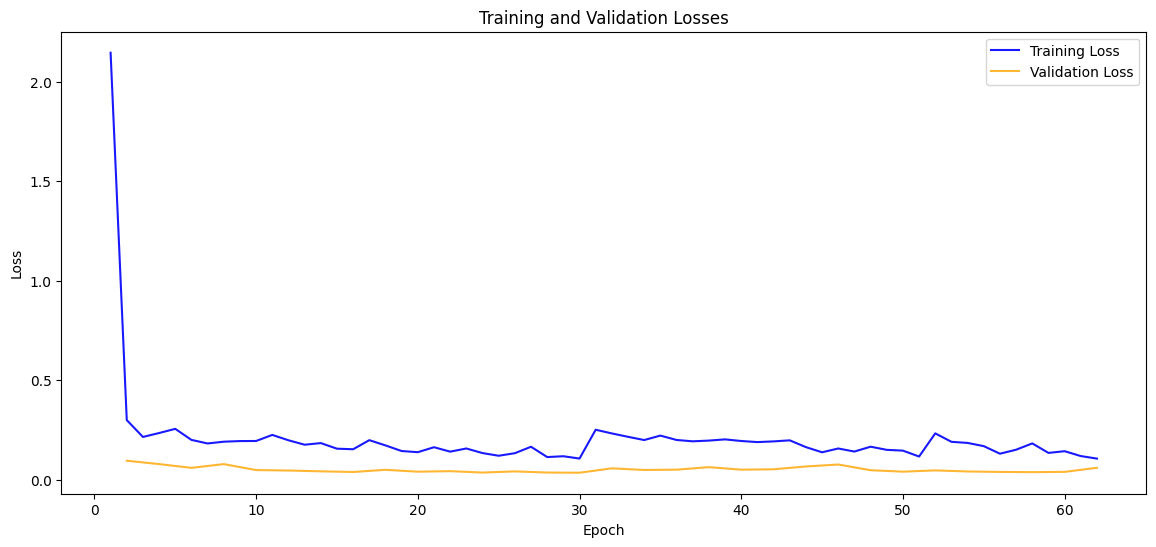

In [ ]:
# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses


train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Filter data starting from epoch 50
start_epoch = 1
train_losses_filtered = train_losses[start_epoch - 1:]
val_losses_filtered = val_losses[(start_epoch - 1) // val_interval:][:len(train_losses_filtered)]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(start_epoch, start_epoch + len(train_losses_filtered)), train_losses_filtered, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(start_epoch + 1, start_epoch + len(train_losses_filtered) + 1, val_interval), val_losses_filtered, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.show()


In [ ]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_3_4_14_35.pth is loading.


In [ ]:
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]

from monai.transforms import Invertd, SaveImaged, Compose, LoadImaged, EnsureChannelFirstd
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch


test_org_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
    ])

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)



100%|██████████| 3/3 [00:12<00:00,  4.28s/it]


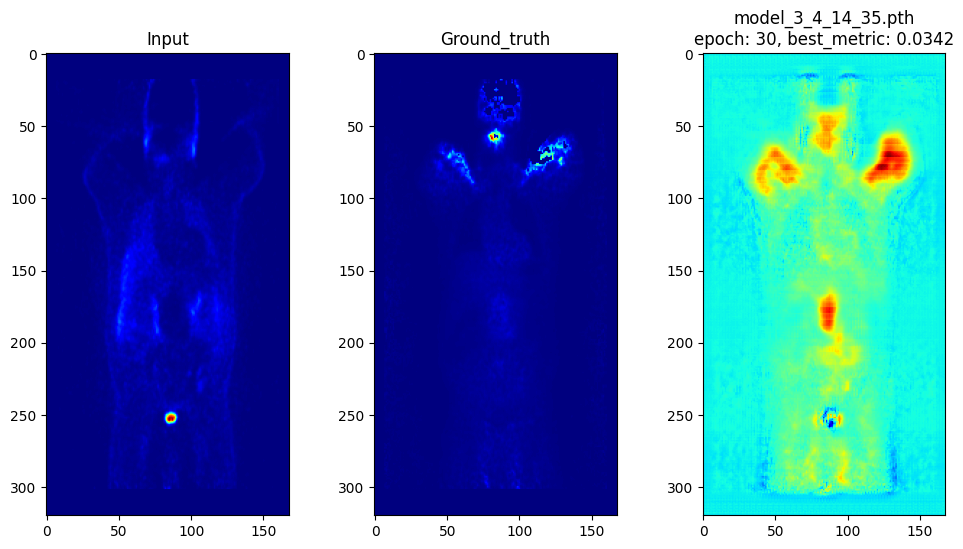

100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


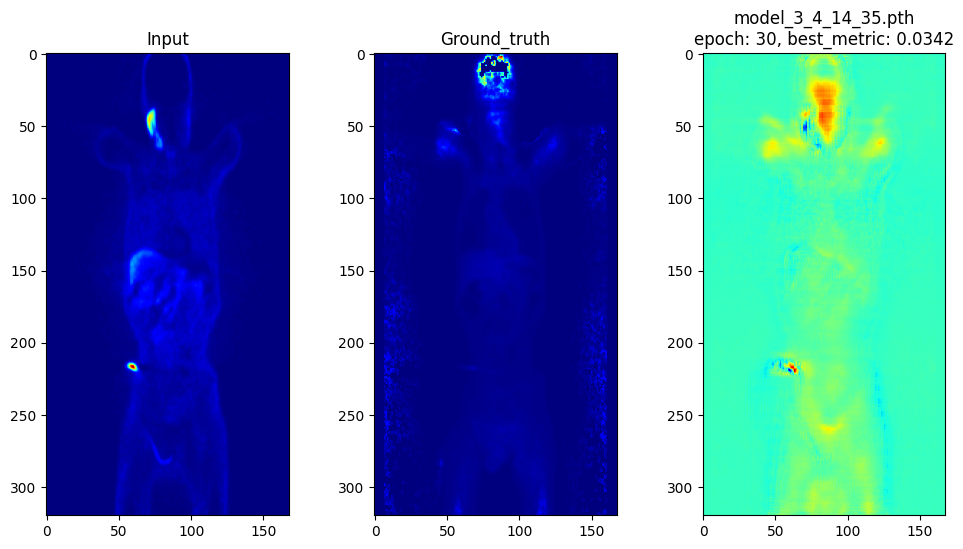

100%|██████████| 3/3 [00:19<00:00,  6.56s/it]


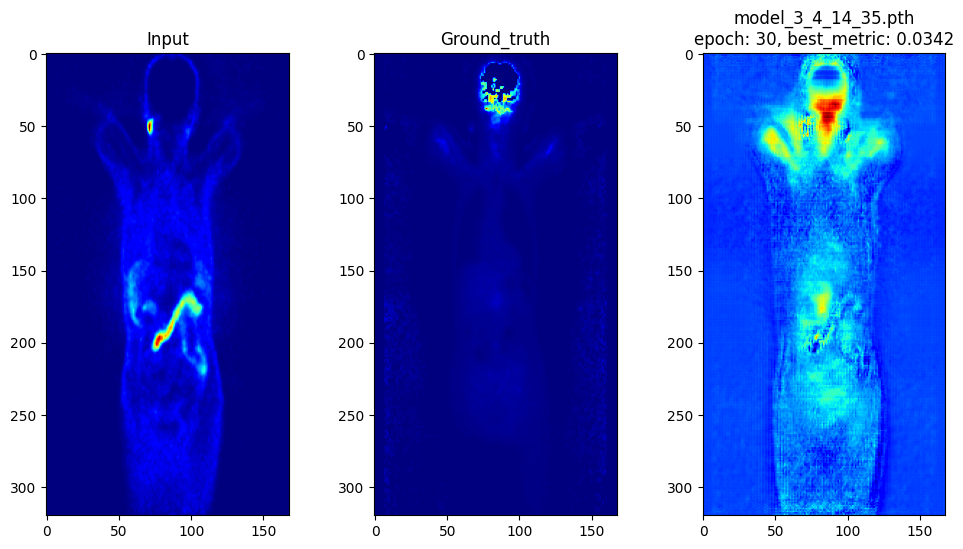

In [ ]:


# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.


    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="jet")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="jet")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="jet")
    
    plt.show()


roi_size = (168, 168, 32)
sw_batch_size = 16
with torch.no_grad():
    for i, val_data in enumerate(test_org_loader):

        n = 80
        visualize_results(val_data, model, n, f"{bestmodel_filename}\nepoch: { best_epoch}, best_metric: {best_metric}")
        if i == 2:
            break




----------
# Export

In [ ]:
import nibabel as nib
import torch

In [ ]:
# Extract file names


# test_org_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#     ]
# )

# test_org_transforms = Compose(
#     [   LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
#         SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
#         CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
#     ])


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=output_dir, output_postfix="dl_adcm", resample=False),
    ]
)
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.70)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]


2024-03-04 17:04:21,753 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004230_C4_SH_/004230_C4_SH__dl_adcm.nii.gz
2024-03-04 17:04:38,933 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004232_C4_SH_/004232_C4_SH__dl_adcm.nii.gz
2024-03-04 17:04:53,924 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004240_C4_SH_/004240_C4_SH__dl_adcm.nii.gz
2024-03-04 17:05:08,152 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004245_C4_SH_/004245_C4_SH__dl_adcm.nii.gz
2024-03-04 17:05:22,262 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004256_C4_SH_/004256_C4_SH__dl_adcm.nii.gz
2024-03-04 17:05:36,568 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004262_C4_SH_/004262_C4_SH__dl_adcm.nii.gz
2024-03-04 17:05:51,072 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/004274_C4_SH_/004274_C4_SH__dl_adcm.nii.gz
2024-03-04 17:06:05,332 INFO image_writer

In [ ]:
import os
import glob

dl_dir = '/homes/zshahpouri/DLP/Practic/OUT/'
org_dir = '/homes/zshahpouri/DLP/ASC-PET-001/MAC'
hint = 'dl_adcm'

# List all DL processed .nii.gz files
dl_files = glob.glob(os.path.join(dl_dir, f'**/*{hint}*.nii.gz'), recursive=True)

# Function to extract the common name from the filename
def extract_common_name(filename):
    # This removes the specific hint and file extension to find the common base name
    return os.path.basename(filename).replace(f'_{hint}', '').split('.')[0]

# Initialize an empty list to hold dictionaries
test_dict_list = []

for dl_path in dl_files:
    common_name = extract_common_name(dl_path)
    # Search for the corresponding original file
    search_pattern = os.path.join(org_dir, f'{common_name}*.nii.gz')
    found_org_files = glob.glob(search_pattern)
    
    if found_org_files:
        # Each pair is stored in a separate dictionary
        pair_dict = {
            'predicted': dl_path,  # DL processed file
            'reference': found_org_files[0]  # Assuming the first match is what you want
        }
        test_dict_list.append(pair_dict)

# Print or use the list of dictionaries as needed
for pair in test_dict_list:
    print(f"Reference: {pair['reference']}, Predicted: {pair['predicted']}")
